In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
file_name = 'Data/SC00001_11-Apr-2019.txt'

In [4]:
usecols = ['trial', 'choice1', 'state', 'choice2', 'won']
file = pd.read_csv(file_name, sep='\t', index_col=0, usecols=usecols, skiprows=lambda x: x in range(3, 11)) # Start analysis at row 10
file = file[file['choice1'] != 0] # Exclude trails that choice1 was missed
file = file[file['choice2'] != 0] # Exclude trails that choice2 was missed
file.head()

,choice1,state,choice2,won
trial,,,,
9,1,2.0,2.0,0.0
10,1,2.0,1.0,1.0
11,1,3.0,1.0,0.0
12,1,2.0,1.0,0.0
13,2,3.0,2.0,0.0


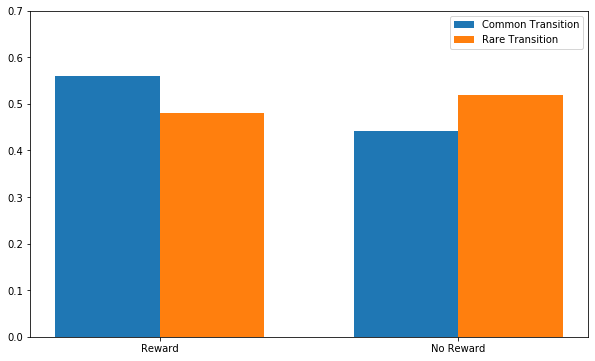

In [5]:
choice1 = file['choice1'] == 1
choice2 = ~choice1
state2 = file['state'] == 2
state3 = ~state2

common = file[(choice1 & state2) | (choice2 & state3)]
rare = file[(choice1 & state3) | (choice2 & state2)]

common_alien1 = common['choice2'] == 1
common_alien2 = ~common_alien1
common_reward = common['won'] == 1
common_noreward = ~common_reward

rare_alien1 = rare['choice2'] == 1
rare_alien2 = ~rare_alien1
rare_reward = rare['won'] == 1
rare_noreward = ~rare_reward

common_alien1_rewards = [len(common[common_alien1 & common_reward]) / len(common),
                         len(common[common_alien1 & common_noreward]) / len(common)]
common_alien2_rewards = [len(common[common_alien2 & common_reward]) / len(common),
                         len(common[common_alien2 & common_noreward]) / len(common)]
rare_alien1_rewards = [len(rare[rare_alien1 & rare_reward]) / len(rare),
                       len(rare[rare_alien1 & rare_noreward]) / len(rare)]
rare_alien2_rewards = [len(rare[rare_alien2 & rare_reward]) / len(rare),
                       len(rare[rare_alien2 & rare_noreward]) / len(rare)]

labels = ['Reward', 'No Reward']
x = np.arange(len(labels))

width = 0.35

fig, ax = plt.subplots(figsize=(10,6))

# ax.bar(x - width / 2, common_alien1_rewards, width, label='Common, Alien 1')
# ax.bar(x - width / 2, common_alien2_rewards, width, bottom=common_alien1_rewards, label='Common, Alien 2')
# ax.bar(x + width / 2, rare_alien1_rewards, width, label='Rare, Alien 1')
# ax.bar(x + width / 2, rare_alien2_rewards, width, bottom=rare_alien1_rewards, label='Rare, Alien 2')

common_rewards = [a1 + a2 for a1, a2 in zip(common_alien1_rewards, common_alien2_rewards)]
rare_rewards = [a1 + a2 for a1, a2 in zip(rare_alien1_rewards, rare_alien2_rewards)]

ax.bar(x - width / 2, common_rewards, width, label='Common Transition')
ax.bar(x + width / 2, rare_rewards, width, label='Rare Transition')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0, 0.7])
ax.legend()
plt.show()

In [6]:
def get_analysis(file):
    com_same_alien = np.array([0, 0])
    com_same_planet = np.array([0, 0])
    rare_same_alien = np.array([0, 0])
    rare_same_planet = np.array([0, 0])

    for i in range(1, len(file)):
        prev_row = file.iloc[i - 1]
        row = file.iloc[i]

        reward_idx = 0 if prev_row['won'] else 1

        # Common Transition
        if (prev_row['choice1'] == 1 and prev_row['state'] == 2) or (prev_row['choice1'] == 2 and prev_row['state'] == 3):
            # Same planet choice
            if prev_row['choice1'] == row['choice1']:
                com_same_planet[reward_idx] += 1
                # Same alien choice
                if prev_row['choice2'] == row['choice2']:
                    com_same_alien[reward_idx] += 1
        # Rare Transition
        else:
            # Same planet choice
            if prev_row['choice1'] == row['choice1']:
                rare_same_planet[reward_idx] += 1
                # Same alien choice
                if prev_row['choice2'] == row['choice2']:
                    rare_same_alien[reward_idx] += 1

    com_same_alien = com_same_alien / sum(com_same_planet)
    com_same_planet = com_same_planet / sum(com_same_planet)
    rare_same_alien = rare_same_alien / sum(rare_same_planet)
    rare_same_planet = rare_same_planet / sum(rare_same_planet)
    
    return com_same_alien, com_same_planet, rare_same_alien, rare_same_planet

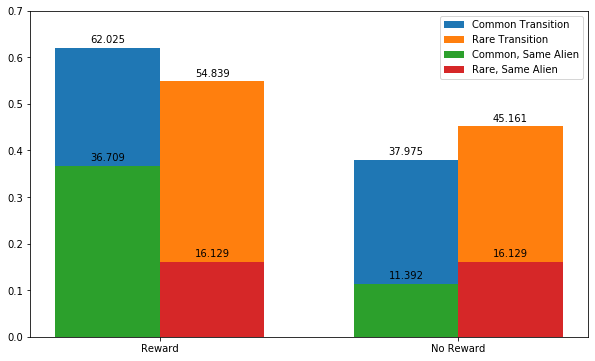

In [7]:
com_same_alien, com_same_planet, rare_same_alien, rare_same_planet = get_analysis(file)

labels = ['Reward', 'No Reward']
x = np.arange(len(labels))

width = 0.35

fig, ax = plt.subplots(figsize=(10,6))

rect1 = ax.bar(x - width / 2, com_same_planet, width, label='Common Transition')
rect2 = ax.bar(x + width / 2, rare_same_planet, width, label='Rare Transition')
rect3 = ax.bar(x - width / 2, com_same_alien, width, label='Common, Same Alien')
rect4 = ax.bar(x + width / 2, rare_same_alien, width, label='Rare, Same Alien')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.3f' % (height * 100),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rect1)
autolabel(rect2)
autolabel(rect3)
autolabel(rect4)

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0, 0.7])
ax.legend()
plt.show()

In [9]:
total_csa = np.array([0, 0])
total_csp = np.array([0, 0])
total_rsa = np.array([0, 0])
total_rsp = np.array([0, 0])

file_dir = os.listdir('Data')
usecols = ['trial', 'choice1', 'state', 'choice2', 'won']
for file_name in file_dir:
    # Start analysis at row 10
    print(file_name)
    file = pd.read_csv('Data/' + file_name, sep='\t', index_col=0, usecols=usecols, skiprows=lambda x: x in range(3, 11))
    file = file[file['choice1'] != 0] # Exclude trials that choice1 was missed
    file = file[file['choice2'] != 0] # Exclude trials that choice2 was missed
    
    csa, csp, rsa, rsp = get_analysis(file)
    
    total_csa += csa

SC00104_27-Sep-2018.txt


TypeError: Cannot cast ufunc add output from dtype('float64') to dtype('int64') with casting rule 'same_kind'